In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings


# Set figure size to (12, 6)
plt.rcParams['figure.figsize'] = (12,6)
warnings.simplefilter('ignore')

#### Load data from .txt file

In [2]:
df = pd.read_csv('/Users/julia/Documents/SPICED/_data/ECA_Tempelhof/TG_STAID002759.txt', header=14)
df

,SOUID,DATE,TG,Q_TG
0,127488,18760101,22,0
1,127488,18760102,25,0
2,127488,18760103,3,0
3,127488,18760104,-58,0
4,127488,18760105,-98,0
...,...,...,...,...
52711,111448,20200426,124,0
52712,111448,20200427,151,0
52713,111448,20200428,170,0
52714,111448,20200429,120,0


In [3]:
#get rid of whitespace in column names
df.columns = [x.strip() for x in df.columns]

In [4]:
df['datetime'] = pd.to_datetime(df['DATE'], format='%Y%m%d')
df['temp'] = df['TG']/10
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day

In [5]:
df.head()

,SOUID,DATE,TG,Q_TG,datetime,temp,year,month,day
0,127488,18760101,22,0,1876-01-01,2.2,1876,1,1
1,127488,18760102,25,0,1876-01-02,2.5,1876,1,2
2,127488,18760103,3,0,1876-01-03,0.3,1876,1,3
3,127488,18760104,-58,0,1876-01-04,-5.8,1876,1,4
4,127488,18760105,-98,0,1876-01-05,-9.8,1876,1,5


In [6]:
df2 = df[(df['datetime'].dt.year >= 1950) & (df['datetime'].dt.year < 2020)]

(728294.0, 731947.0)

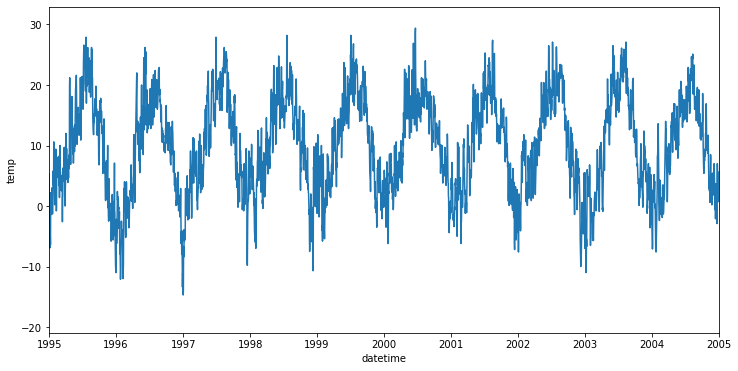

In [7]:
ax = sns.lineplot(x='datetime', y='temp', data=df2)
ax.set_xlim(pd.to_datetime('1995'), pd.to_datetime('2005'))

<Figure size 432x1296 with 0 Axes>

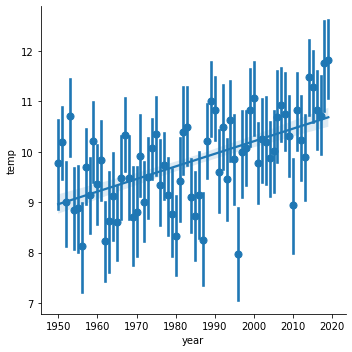

In [8]:
plt.figure(figsize=(6,18))
ax = sns.lmplot(x="year", y="temp", data=df2, x_estimator=np.mean)

### Remove the trend - differencing

In [9]:
df2['diff'] = df2['temp'].diff().fillna(0)
df2.head()

,SOUID,DATE,TG,Q_TG,datetime,temp,year,month,day,diff
27028,111448,19500101,-35,0,1950-01-01,-3.5,1950,1,1,0.0
27029,111448,19500102,10,0,1950-01-02,1.0,1950,1,2,4.5
27030,111448,19500103,29,0,1950-01-03,2.9,1950,1,3,1.9
27031,111448,19500104,-1,0,1950-01-04,-0.1,1950,1,4,-3.0
27032,111448,19500105,-30,0,1950-01-05,-3.0,1950,1,5,-2.9


In [10]:
df2['diff'].mean(), df2['diff'].std()

(0.00037157273047287297, 2.381606404909236)

(728294.0, 731947.0)

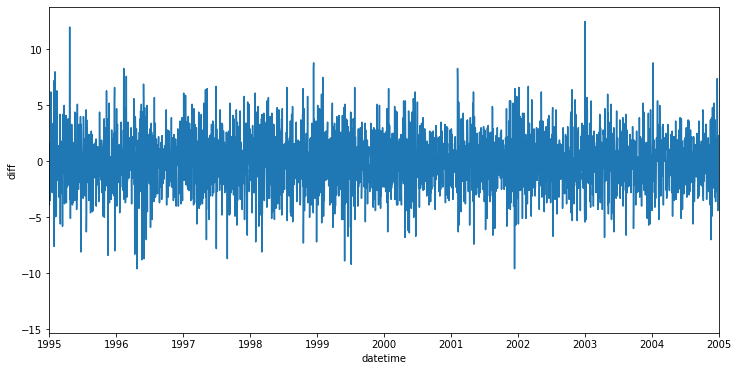

In [11]:
ax = sns.lineplot(x='datetime', y='diff', data=df2)
ax.set_xlim(pd.to_datetime('1995'), pd.to_datetime('2005'))

### Remove seasonality

In [12]:
df2['daily_mean'] = df2.groupby(['month', 'day'])['diff'].transform('mean')
df2['deseason'] = df2['diff'] - df2['daily_mean']

(728294.0, 731947.0)

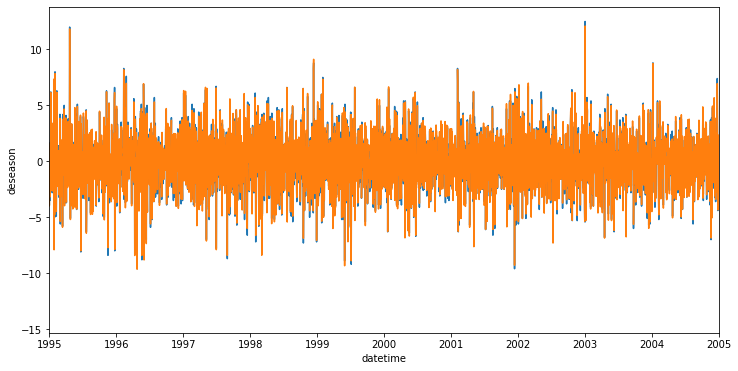

In [13]:
ax = sns.lineplot(x="datetime", y="diff", data=df2)
sns.lineplot(x="datetime", y="deseason", data=df2)
ax.set_xlim(pd.to_datetime('1995'), pd.to_datetime('2005'))


In [14]:
df2['deseason'].mean(), df2['deseason'].std()

(4.186079695461536e-18, 2.362586605582337)

In [15]:
df2['daily_mean_temp'] = df2.groupby(['month','day'])['temp'].transform('mean')

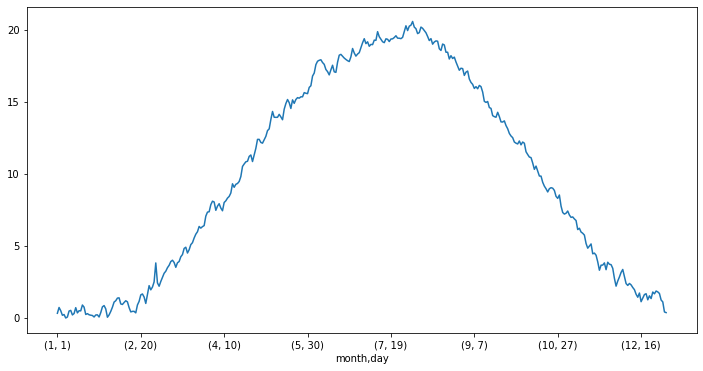

In [16]:
# mean temperatures of each day in the year
df2.groupby(['month','day'])['temp'].mean().plot()

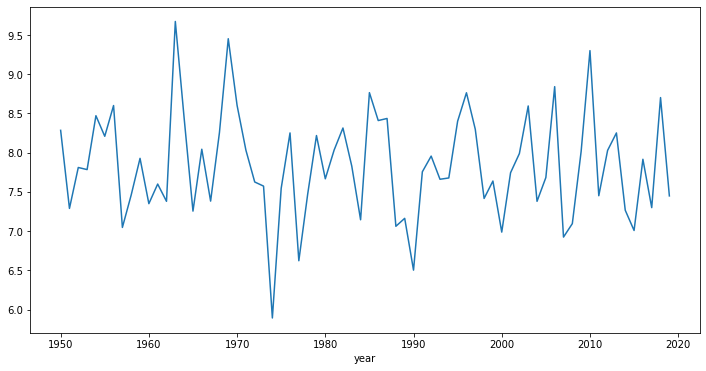

In [17]:
# check if volatility changes over time
df2.groupby(['year'])['temp'].std().plot()

In [38]:
# train test split is a little bit different for time-dependent data
Xtrain = df2[df2['datetime'] < pd.to_datetime('2005-01-01')].drop('temp', axis=1)
Xtest = df2[df2['datetime'] >= pd.to_datetime('2005-01-01')].drop('temp', axis=1)
ytrain = df2[df2['datetime'] < pd.to_datetime('2005-01-01')]['temp']
ytest = df2[df2['datetime'] >= pd.to_datetime('2005-01-01')]['temp']

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((20089, 12), (5478, 12), (20089,), (5478,))

In [29]:
Xtrain

,SOUID,DATE,TG,Q_TG,datetime,year,month,day,diff,daily_mean,deseason,daily_mean_temp
27028,111448,19500101,-35,0,1950-01-01,1950,1,1,0.0,0.090000,-0.090000,0.298571
27029,111448,19500102,10,0,1950-01-02,1950,1,2,4.5,0.401429,4.098571,0.700000
27030,111448,19500103,29,0,1950-01-03,1950,1,3,1.9,-0.222857,2.122857,0.477143
27031,111448,19500104,-1,0,1950-01-04,1950,1,4,-3.0,-0.317143,-2.682857,0.160000
27032,111448,19500105,-30,0,1950-01-05,1950,1,5,-2.9,0.050000,-2.950000,0.210000
...,...,...,...,...,...,...,...,...,...,...,...,...
47112,111448,20041227,24,0,2004-12-27,2004,12,27,0.8,-0.111429,0.911429,1.671429
47113,111448,20041228,7,0,2004-12-28,2004,12,28,-1.7,-0.451429,-1.248571,1.220000
47114,111448,20041229,18,0,2004-12-29,2004,12,29,1.1,-0.132857,1.232857,1.087143
47115,111448,20041230,32,0,2004-12-30,2004,12,30,1.4,-0.697143,2.097143,0.390000


(730120.0, 733773.0)

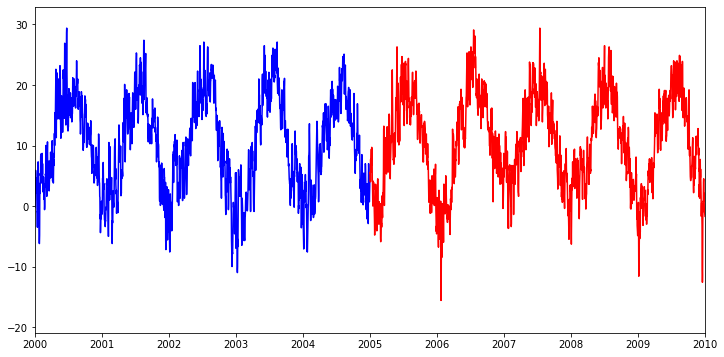

In [32]:
ax = plt.plot(Xtrain['datetime'], ytrain, 'b-')
plt.plot(Xtest['datetime'], ytest, 'r-')
plt.xlim(pd.to_datetime('2000'), pd.to_datetime('2010'))

### Naive forcasts
**Forecast last value seen**

In [40]:
ypred_last = [list(ytrain)[-1]]*len(ytest)

(730120.0, 733773.0)

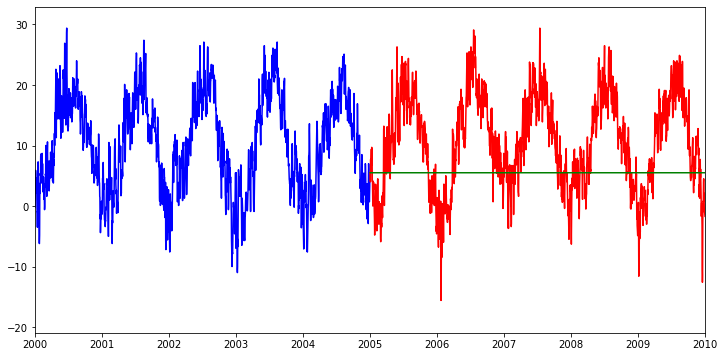

In [42]:
ax = plt.plot(Xtrain['datetime'], ytrain, 'b-')
plt.plot(Xtest['datetime'], ytest, 'r-')
plt.plot(Xtest['datetime'], ypred_last, 'g-')
#plt.plot(xtest, ypred_mean, 'k-')
#plt.plot(xtest, ypred_sm, 'purple')
plt.xlim(pd.to_datetime('2000'), pd.to_datetime('2010'))

**Forecast mean**

In [43]:
mean = sum(ytrain) / len(ytrain)
ypred_mean = [mean]*len(ytest)

(730120.0, 733773.0)

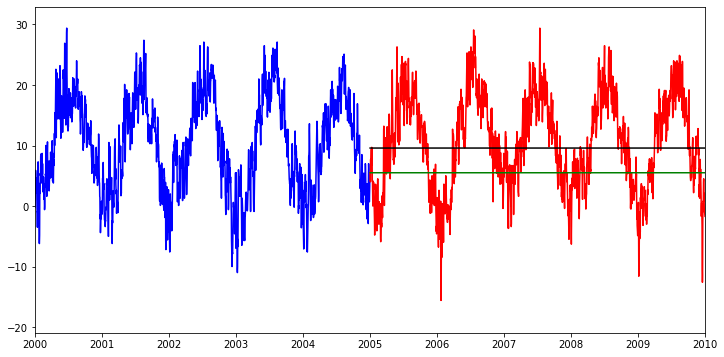

In [44]:
ax = plt.plot(Xtrain['datetime'], ytrain, 'b-')
plt.plot(Xtest['datetime'], ytest, 'r-')
plt.plot(Xtest['datetime'], ypred_last, 'g-')
plt.plot(Xtest['datetime'], ypred_mean, 'k-')
#plt.plot(xtest, ypred_sm, 'purple')
plt.xlim(pd.to_datetime('2000'), pd.to_datetime('2010'))

**Forecast the seasonal mean**

In [55]:
ypred_sm = []
for i in range(1,13):
    for j in Xtest[Xtest['month'] == i]['day']:
        print(j)
       
    
    
    #month = i % 12 # modulo - good for everything cyclic
    #month_mean = sum(ytrain[month::12]) / len(ytrain[month::12])
    #ypred_sm.append(month_mean)
#ypred_sm

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
2

22
23
24
25
26
27
28
29
30
31
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
2

In [60]:
Xtrain[Xtrain['month'] == 1].groupby(['day']).mean()

,SOUID,DATE,TG,Q_TG,year,month,diff,daily_mean,deseason,daily_mean_temp
day,,,,,,,,,,
1,111448.0,19770101.0,-5.636364,0.0,1977.0,1.0,-0.138182,0.090000,-0.228182,0.298571
2,111448.0,19770102.0,2.854545,0.0,1977.0,1.0,0.849091,0.401429,0.447662,0.700000
3,111448.0,19770103.0,2.654545,0.0,1977.0,1.0,-0.020000,-0.222857,0.202857,0.477143
4,111448.0,19770104.0,-3.181818,0.0,1977.0,1.0,-0.583636,-0.317143,-0.266494,0.160000
5,111448.0,19770105.0,-0.472727,0.0,1977.0,1.0,0.270909,0.050000,0.220909,0.210000
6,111448.0,19770106.0,-1.000000,0.0,1977.0,1.0,-0.052727,-0.238571,0.185844,-0.028571
7,111448.0,19770107.0,-2.509091,0.0,1977.0,1.0,-0.150909,0.067143,-0.218052,0.038571
8,111448.0,19770108.0,-0.745455,0.0,1977.0,1.0,0.176364,0.414286,-0.237922,0.452857
9,111448.0,19770109.0,-1.236364,0.0,1977.0,1.0,-0.049091,0.045714,-0.094805,0.498571
